In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 8192),
            nn.ReLU(),
            nn.Linear(8192, output_dim),
            nn.Tanh()
                    
            
        )
        
    def forward(self, x):
        return self.net(x) *10

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
            
            
        )
        
    def forward(self, x):
        return self.net(x)

def initialize_weights_he(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Leer datos
expression_data = pd.read_csv('exprLOW.csv')
methylation_data = pd.read_csv('methylLOW.csv')
assign_data = pd.read_csv('assignLOW.csv')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expression_data.fillna(0, inplace=True)
methylation_data.fillna(0, inplace=True)
assign_data.fillna(0, inplace=True)

expression_data = expression_data.values
methylation_data = methylation_data.values
assign_data=assign_data.values
# Asegurar que tienes el mismo número de muestras en ambos conjuntos de datos


assert expression_data.shape[0] == methylation_data.shape[0], "Los datos de expresión y metilación deben tener el mismo número de muestras."
assert assign_data.shape[0] == methylation_data.shape[0], "Los datos de asignación y metilación deben tener el mismo número de muestras."

# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
expression_data = torch.FloatTensor(expression_data).to(device)
methylation_data = torch.FloatTensor(methylation_data).to(device)
assign_data = torch.FloatTensor(assign_data).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)

True


In [91]:





# Modelos y optimizadores
gen = Generator(100, expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
disc = Discriminator(expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen.apply(initialize_weights_he) 
disc.apply(initialize_weights_he) 
print(f'El modelo Generator tiene {count_parameters(gen)} parámetros entrenables.')
print(f'El modelo Discriminator tiene {count_parameters(disc)} parámetros entrenables.')
gen_optimizer = optim.RMSprop(gen.parameters(), lr=0.0002)
disc_optimizer = optim.RMSprop(disc.parameters(), lr=0.00003)
criterion = nn.BCELoss()

# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 64
n_epochs = 10000
start_time = time.time()
for epoch in range(n_epochs):
    for idx in range(0, n_samples, batch_size):
        real_data = combined_data[idx:idx+batch_size].to(device)
        current_batch_size = real_data.size(0)
        real_labels = torch.ones(current_batch_size, 1).to(device)

        noise = torch.randn(current_batch_size, 100).to(device)
        #noise = expression_data[idx:idx+batch_size]
        
        fake_data = gen(noise).to(device)
        if ((epoch+1) % 100 == 0) and (idx ==0):
            print(fake_data)
        #fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl), 1)

        #fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl ), 1).to(device)

        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        
        # Entrenar discriminador
        disc_optimizer.zero_grad()

        real_preds = disc(real_data).to(device)
        real_loss = criterion(real_preds, real_labels)
        
        fake_preds = disc(fake_data).to(device)
        fake_loss = criterion(fake_preds, fake_labels)

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        if ((epoch+1) % 100 == 0):
            print("Discriminator Weights")
            for name, param in disc.named_parameters():
                if param.requires_grad:
                    print(name, param.grad.data.sum())
        disc_optimizer.step()

        # Entrenar generador
        gen_optimizer.zero_grad()

        noise = torch.randn(current_batch_size, 100).to(device)
        fake_data = gen(noise).to(device)
        #fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl ), 1).to(device)
        fake_preds = disc(fake_data).to(device)

        gen_loss = criterion(fake_preds, real_labels)
        gen_loss.backward()
        if ((epoch+1) % 100 == 0):
            print("Generator Weights")
            for name, param in gen.named_parameters():
                if param.requires_grad:
                    print(name, param.grad.data.sum())
        gen_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Disc Loss: {disc_loss.item()} | Gen Loss: {gen_loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()
        if(gen_loss.item()>99 or disc_loss.item()>99): 
            break

print("FIN")
torch.save(gen.state_dict(), 'generator_modelB.pth')




El modelo Generator tiene 63035891 parámetros entrenables.
El modelo Discriminator tiene 519425 parámetros entrenables.
tensor([[ 10., -10., -10.,  ...,  10.,  10., -10.],
        [ 10., -10., -10.,  ...,  10.,  10., -10.],
        [ 10., -10., -10.,  ...,  10.,  10., -10.],
        ...,
        [ 10., -10., -10.,  ...,  10.,  10., -10.],
        [ 10., -10., -10.,  ...,  10.,  10., -10.],
        [ 10., -10., -10.,  ...,  10.,  10., -10.]], device='cuda:0',
       grad_fn=<MulBackward0>)
Discriminator Weights
net.0.weight tensor(0., device='cuda:0')
net.0.bias tensor(0., device='cuda:0')
net.3.weight tensor(0., device='cuda:0')
net.3.bias tensor(0., device='cuda:0')
net.6.weight tensor(0., device='cuda:0')
net.6.bias tensor(0., device='cuda:0')
net.9.weight tensor(0., device='cuda:0')
net.9.bias tensor(0., device='cuda:0')
Generator Weights
net.0.weight tensor(0., device='cuda:0')
net.0.bias tensor(0., device='cuda:0')
net.2.weight tensor(0., device='cuda:0')
net.2.bias tensor(0., dev

SVC: Solo una clase


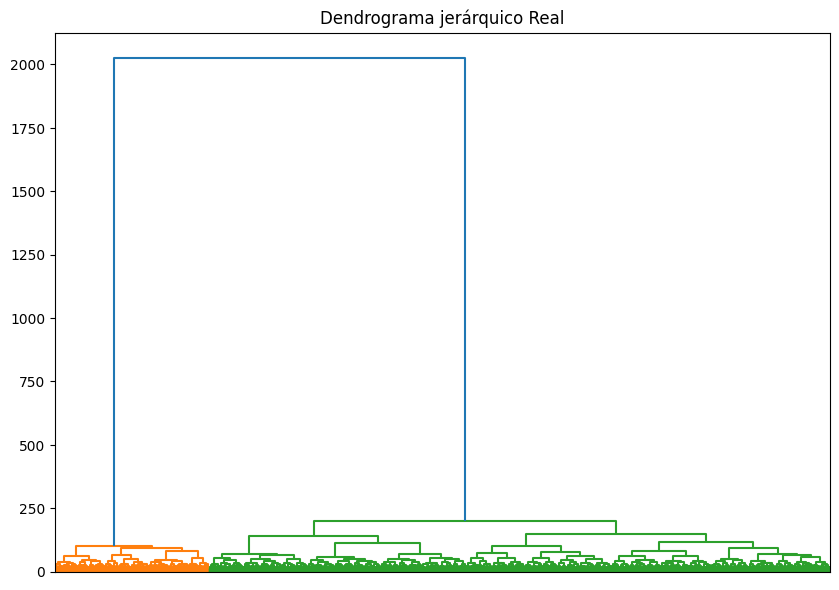

/home/fede/PyEnv/PB/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:2844: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


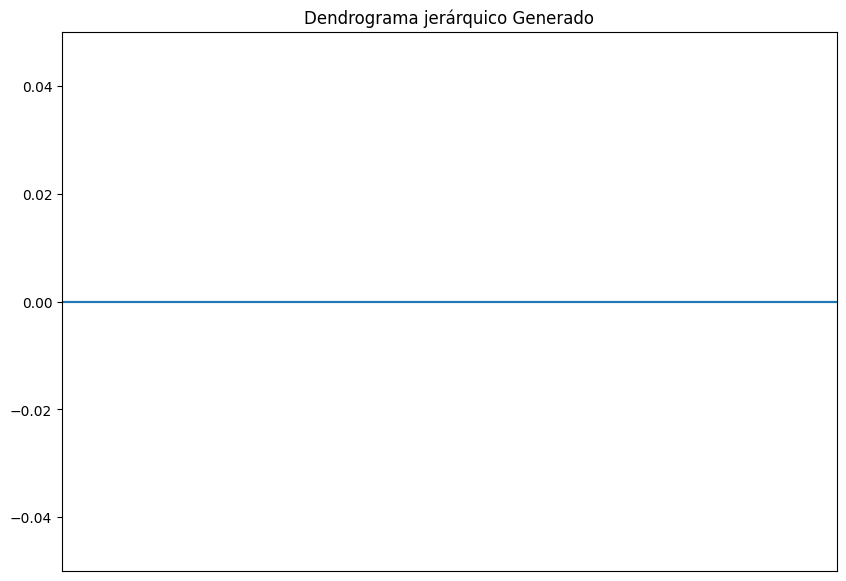

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


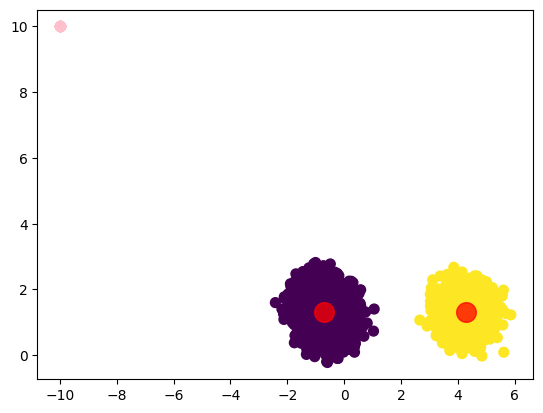

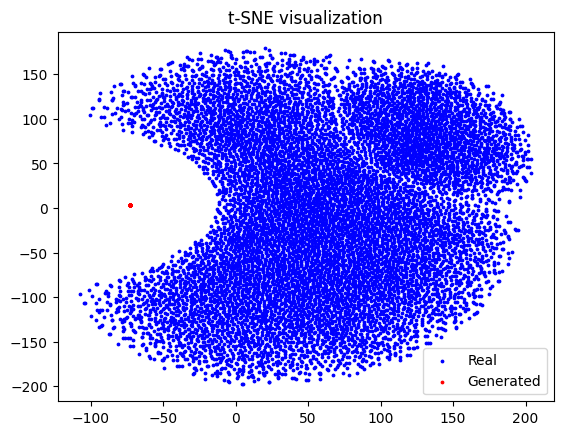

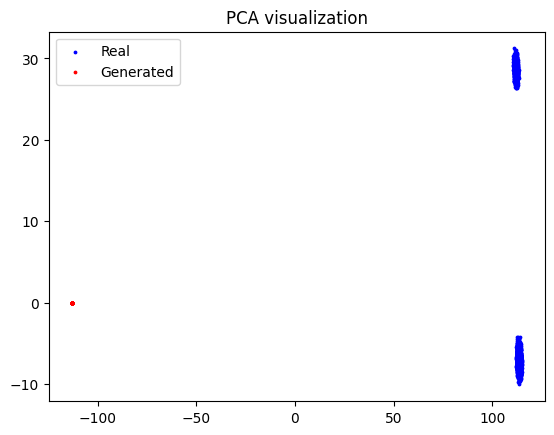

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


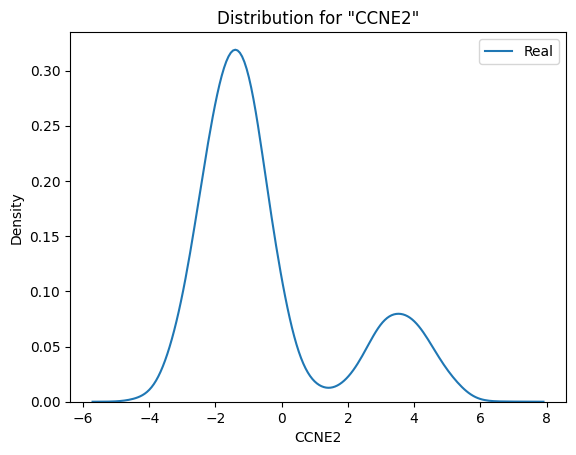

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


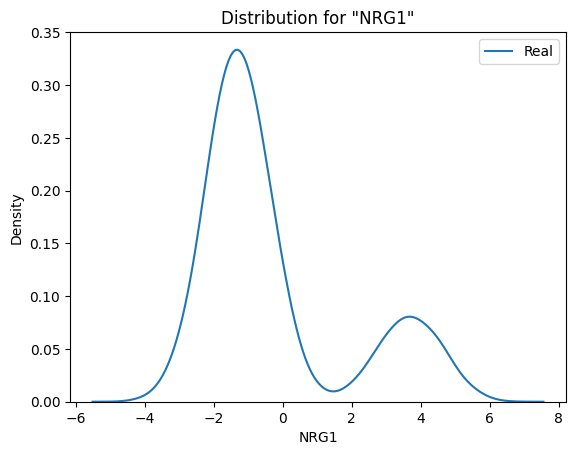

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


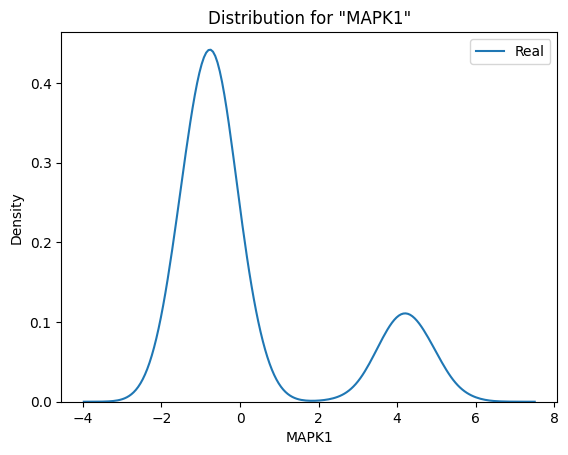

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


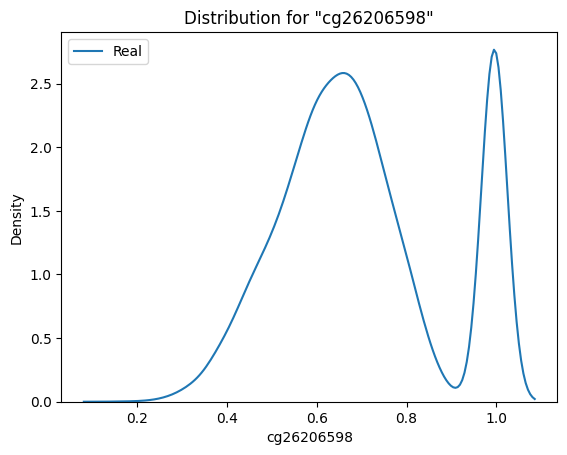

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


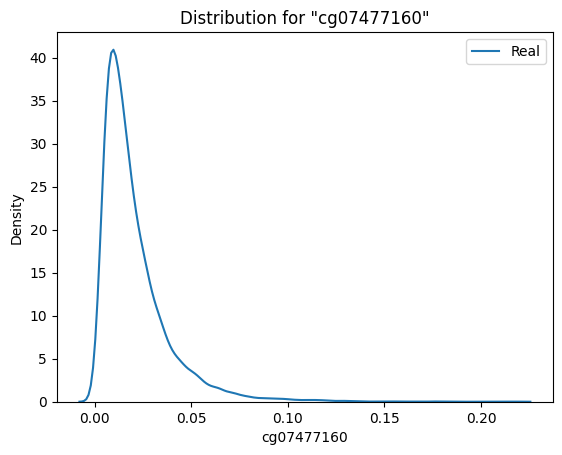

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


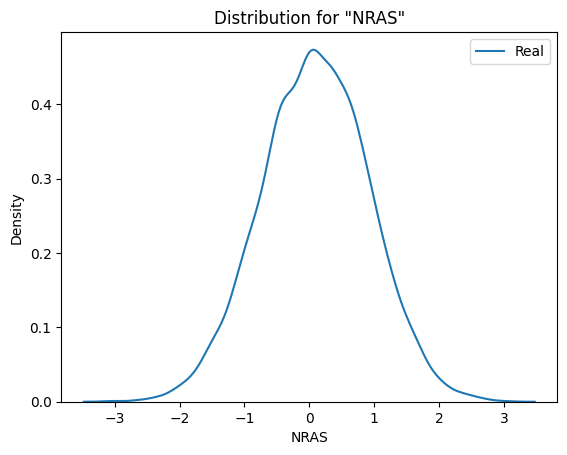

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


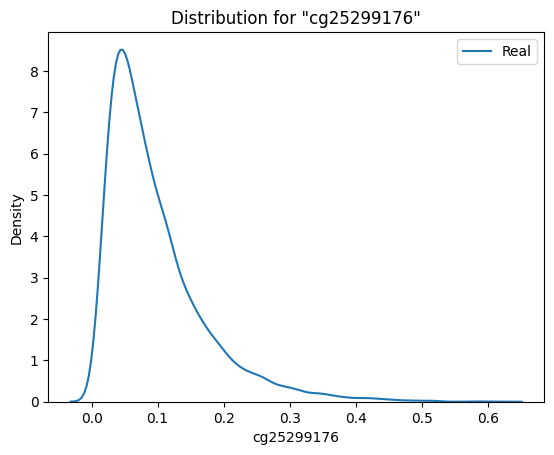

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


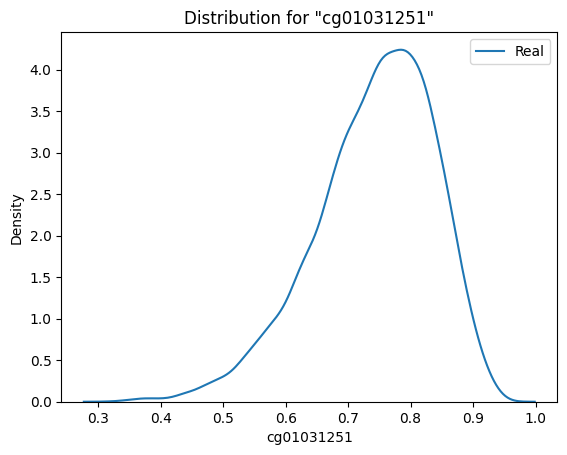

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


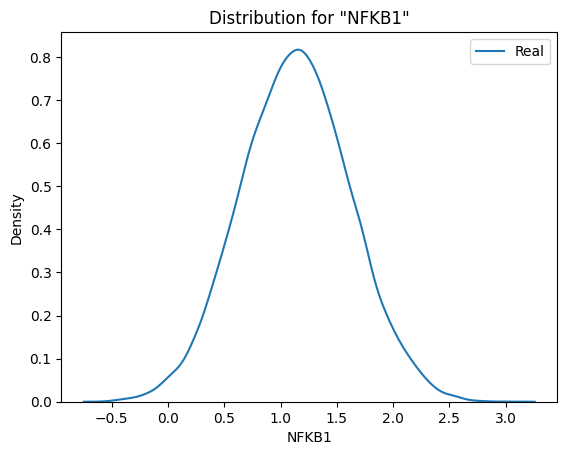

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


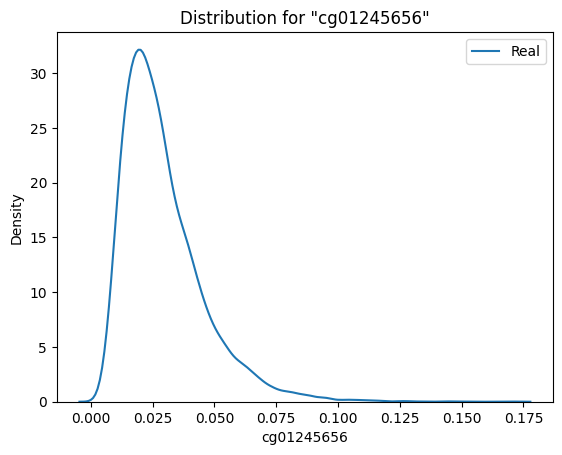

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


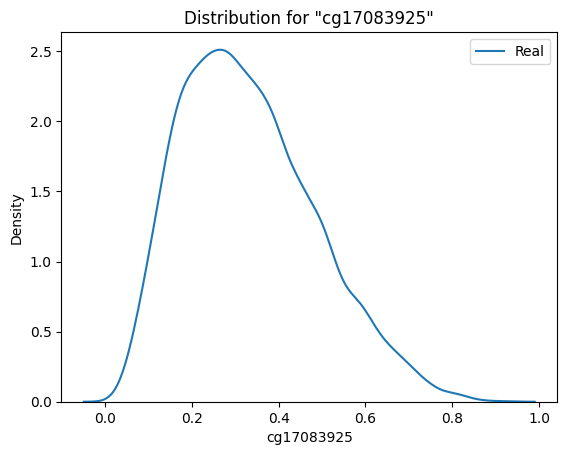

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


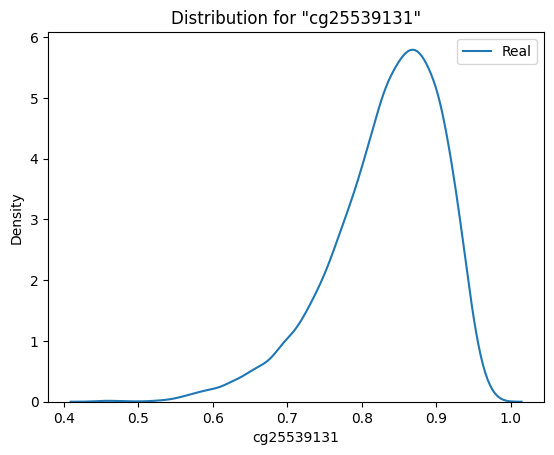

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


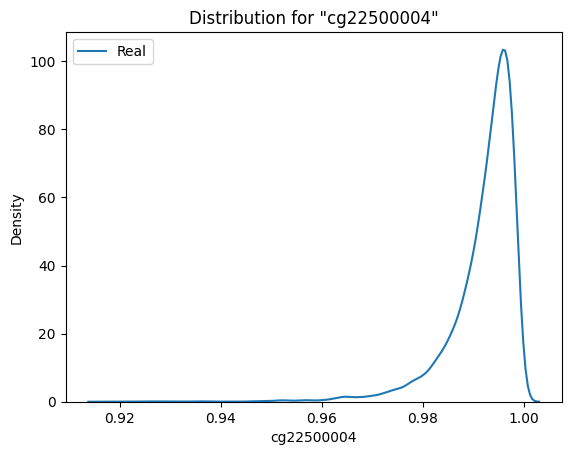

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


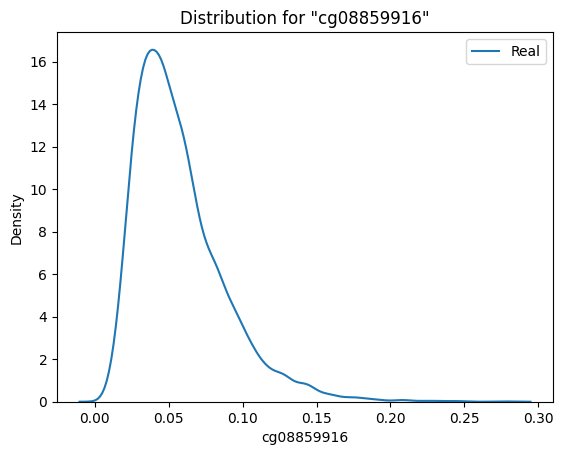

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


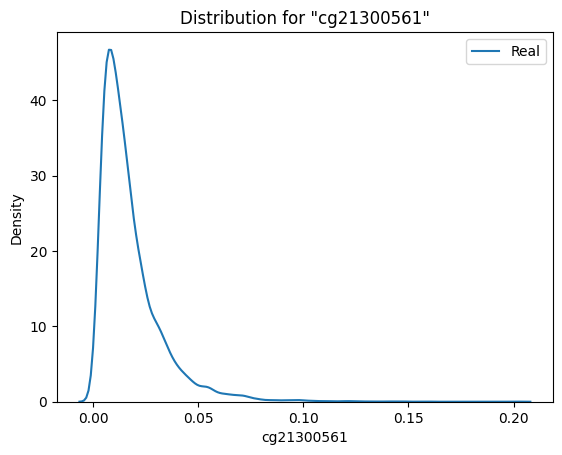

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


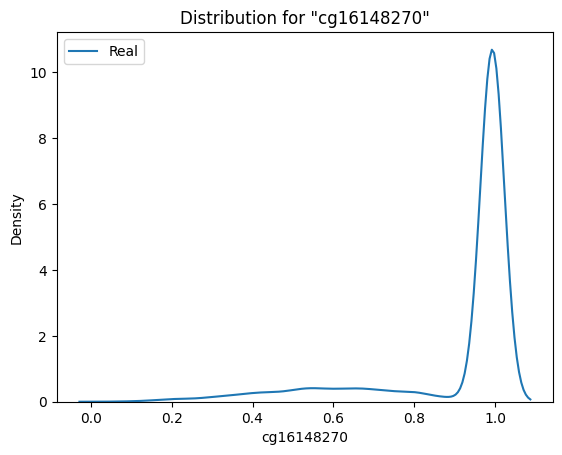

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


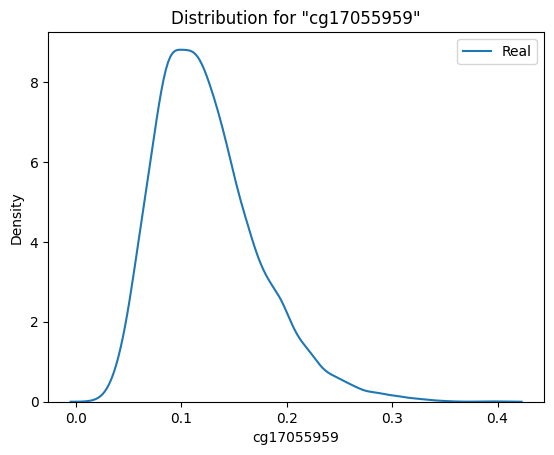

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


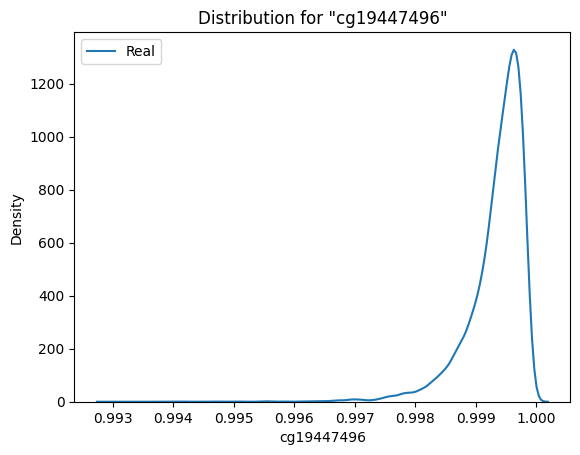

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


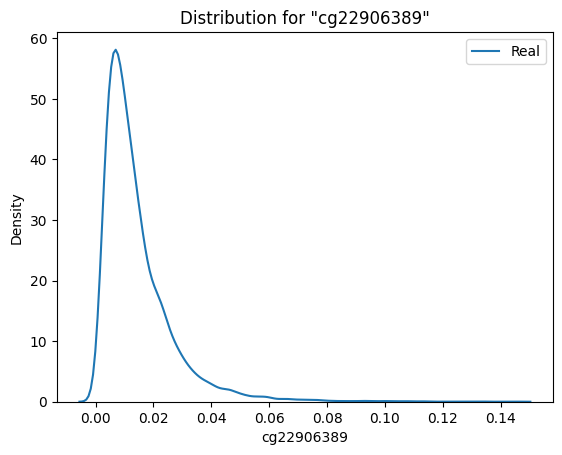

/tmp/ipykernel_77193/1183685863.py:161: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_gan[column_name], label='Generated')


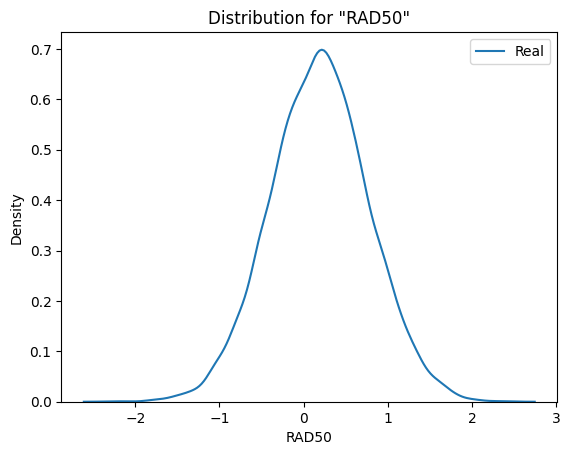

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sys
sys.setrecursionlimit(20000)
filename = "modelfull24-"
# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)

# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"


# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Generar datos de expresión sintética
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_modelB.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)
#X = X.apply(pd.to_numeric, errors='coerce')
y = X_gan.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X_gan.iloc[:, :-1]

last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])






# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    clf.fit(X_train, y_train)
    # Predicciones
    y_pred = clf.predict(X_test)
    
    # Métricas de clasificación
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.savefig(filename+"SVC.jpg")
    plt.show()
else:
    print("SVC: Solo una clase")



# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Real")
plt.savefig(filename+"DJR.jpg")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Generado")
plt.savefig(filename+"DJG.jpg")
plt.show()


# K-Means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_real)
labels = kmeans.predict(X_real)
centroids = kmeans.cluster_centers_
X_array = X_real.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.savefig(filename+"KNN.jpg")
plt.show()

# Aplicar t-SNE
# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Dibujar el resultado
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()


#KDE
# Suponiendo que X_real y X_gan tienen las mismas columnas
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)
for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real')
    sns.kdeplot(X_gan[column_name], label='Generated')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(filename+"kde-"+column_name+".jpg")
    plt.show()

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


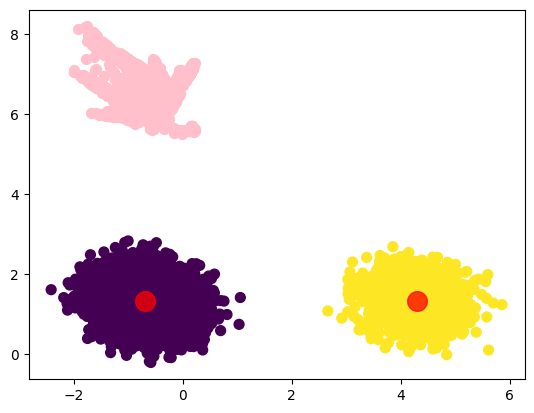

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = pd.concat([expr_data, meth_data], axis=1)


gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_modelB.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)
last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])

# Número de clusters
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_
X_array = X.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.show()



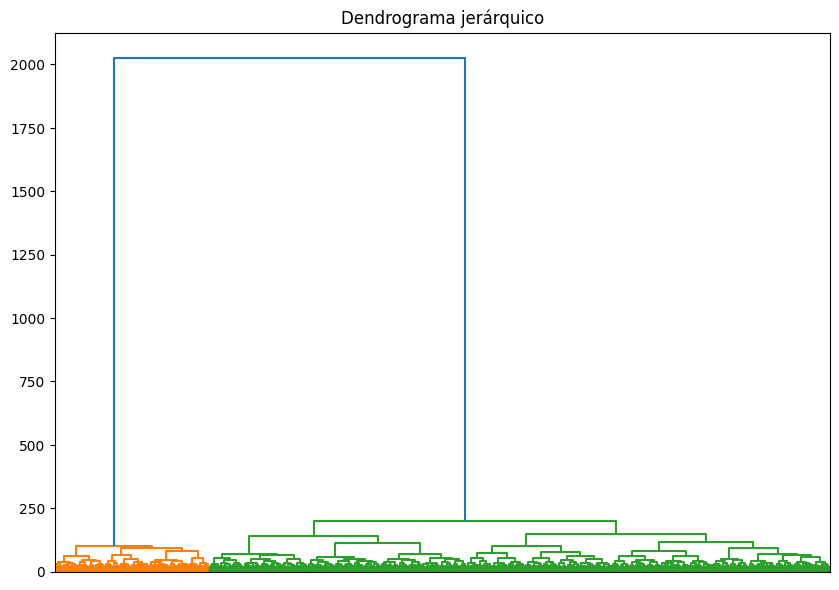

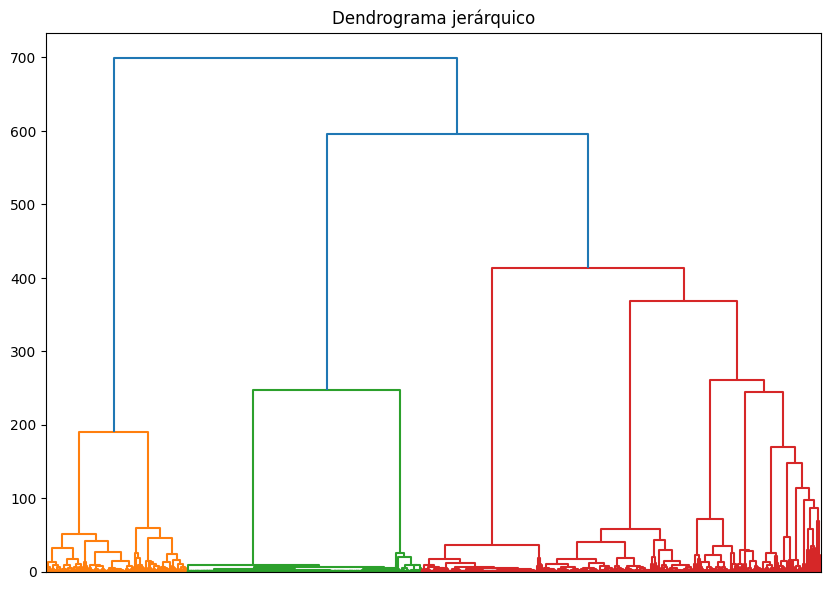

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)

# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"


# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Genera tus datos con el GAN (ejemplo)
# X_gan = generador(noise).data.cpu().numpy()  # Asume que tienes una función generador
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_modelB.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)
last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])

# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])

# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])

# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico")
plt.show()




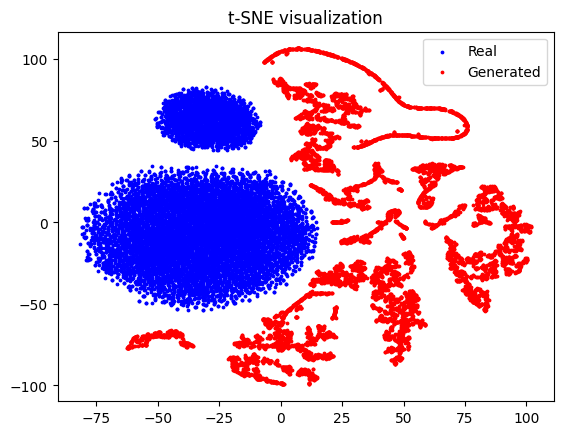

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from sklearn.manifold import TSNE

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)

# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"


# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Genera tus datos con el GAN (ejemplo)
# X_gan = generador(noise).data.cpu().numpy()  # Asume que tienes una función generador
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_modelB.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)
last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])

# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])

# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Dibujar el resultado
plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.show()

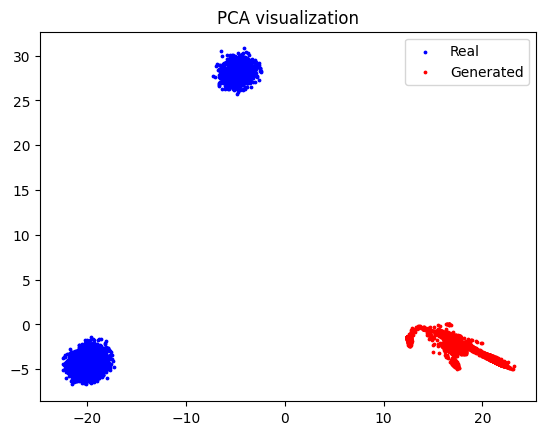

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from sklearn.decomposition import PCA

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)

# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"


# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Genera tus datos con el GAN (ejemplo)
# X_gan = generador(noise).data.cpu().numpy()  # Asume que tienes una función generador
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_modelB.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)
last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])

# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])

# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Dibujar el resultado
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.show()

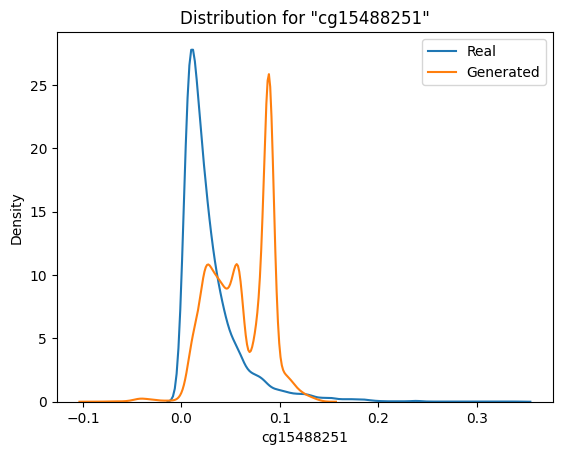

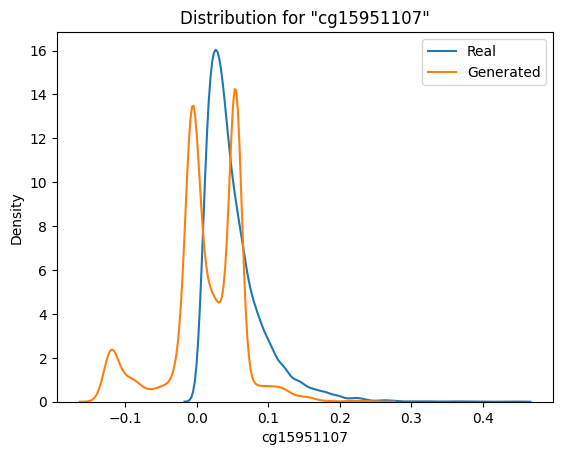

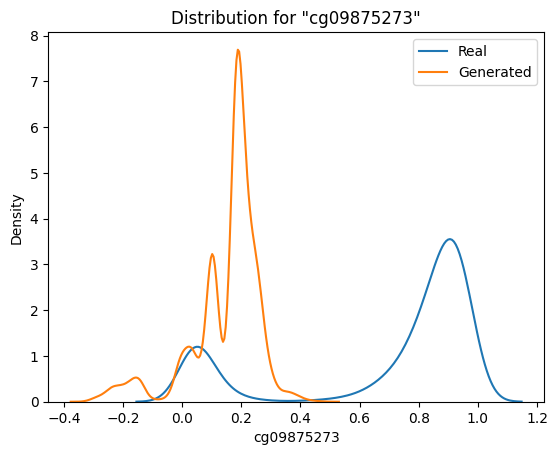

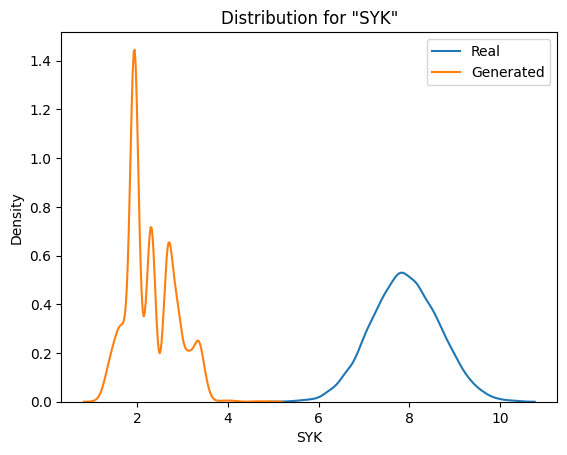

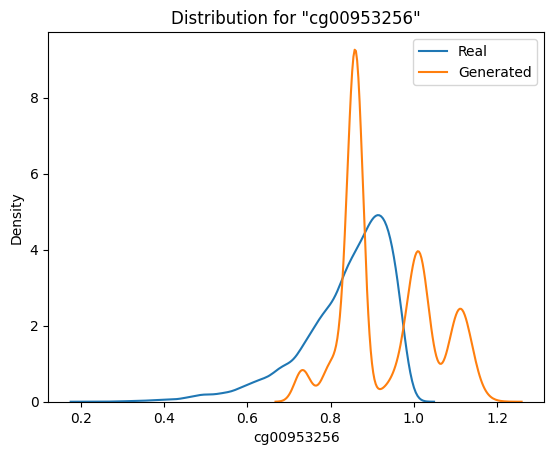

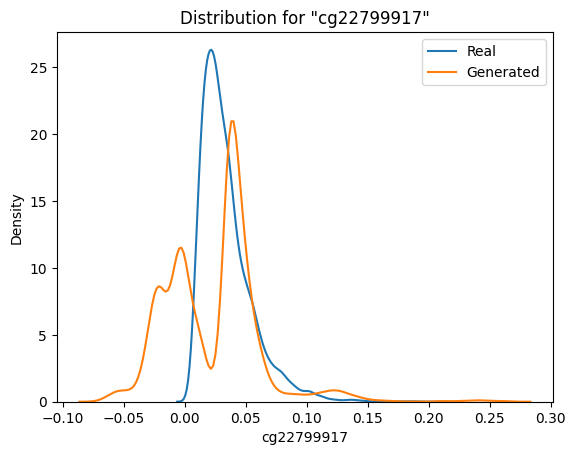

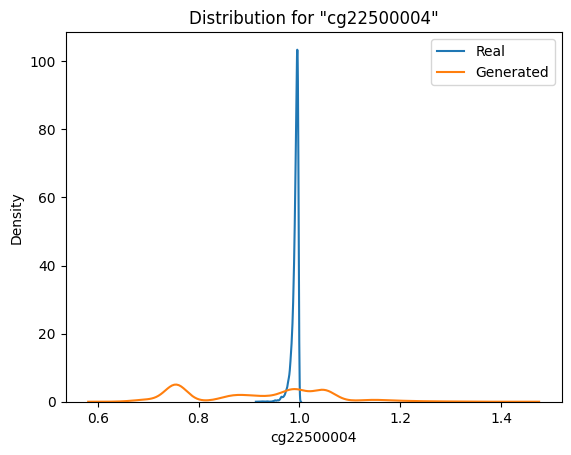

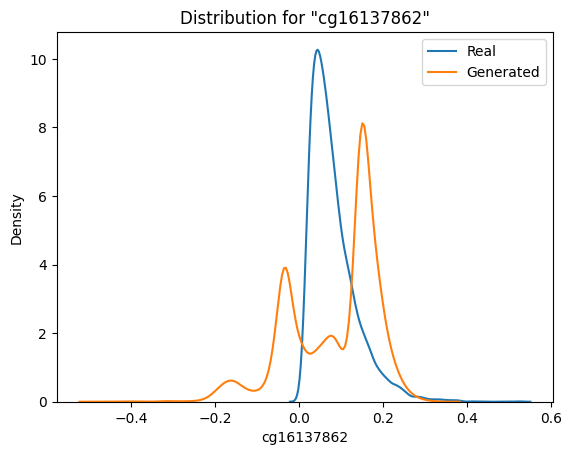

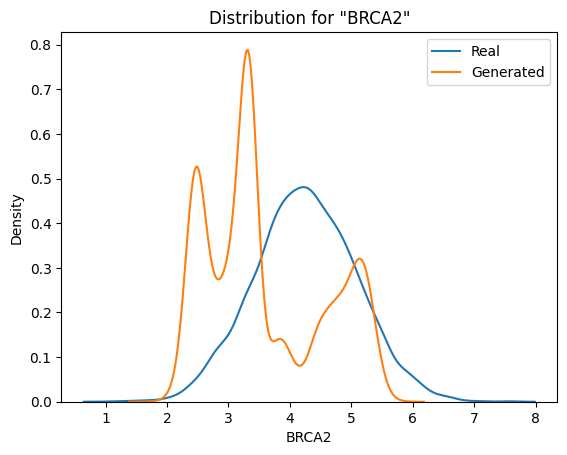

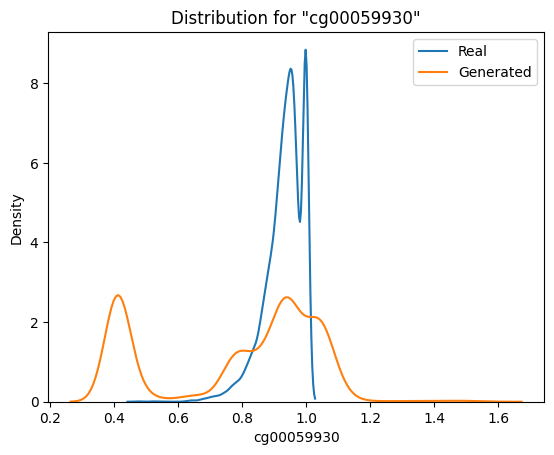

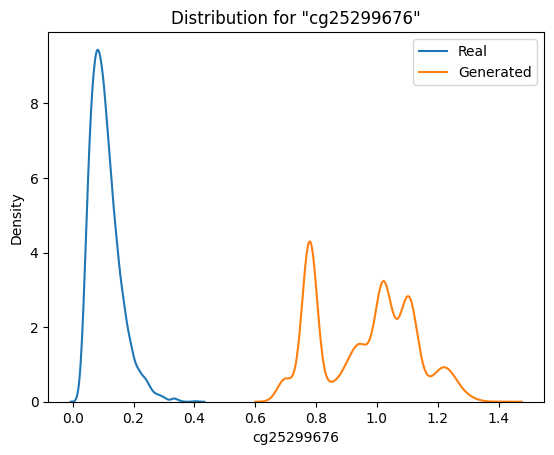

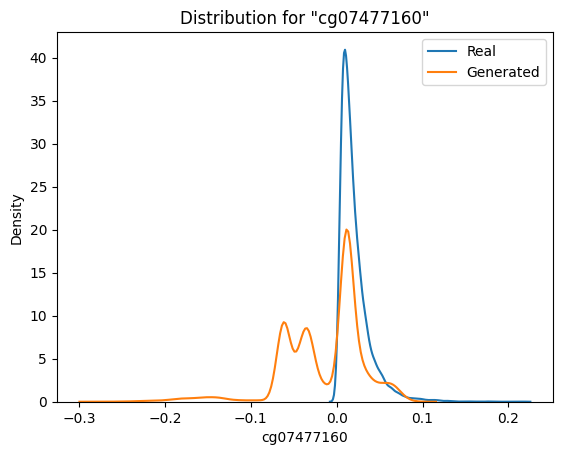

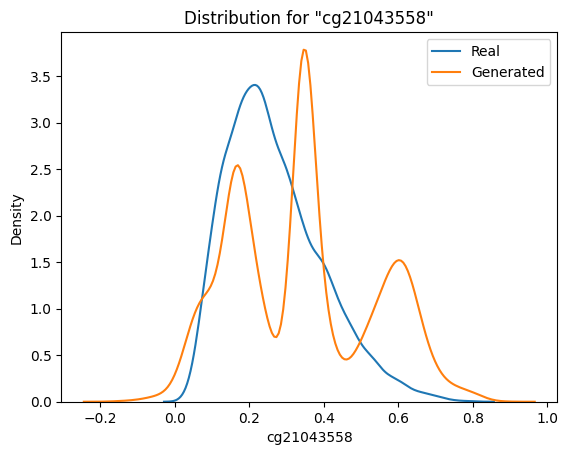

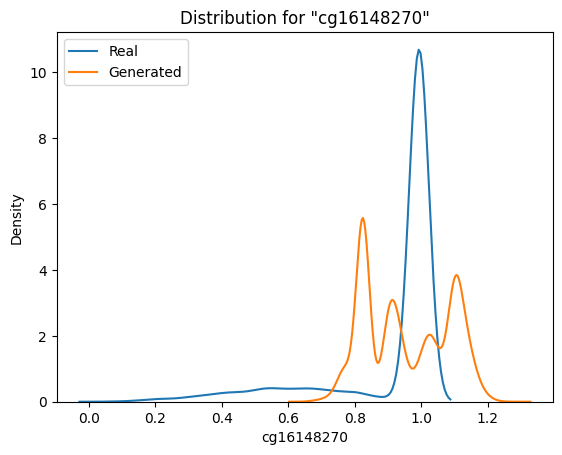

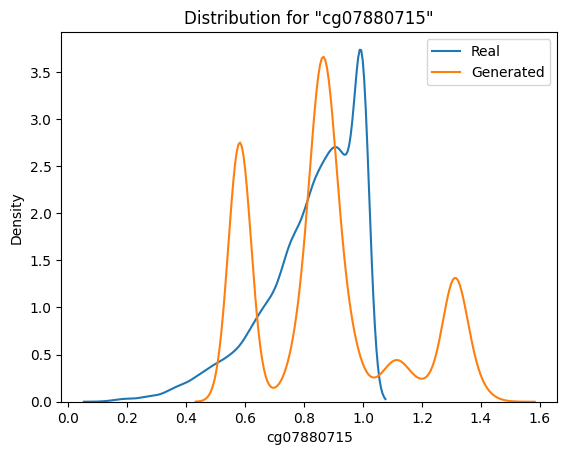

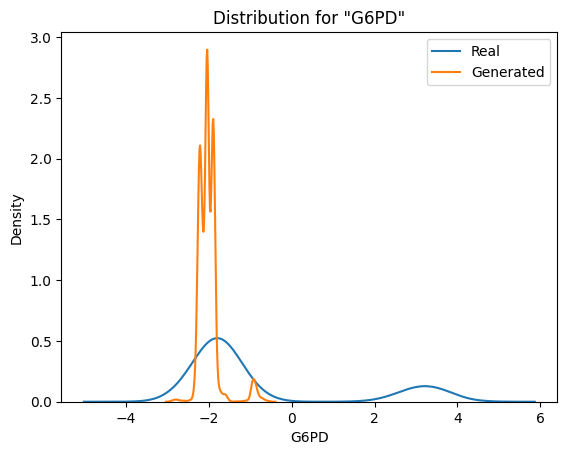

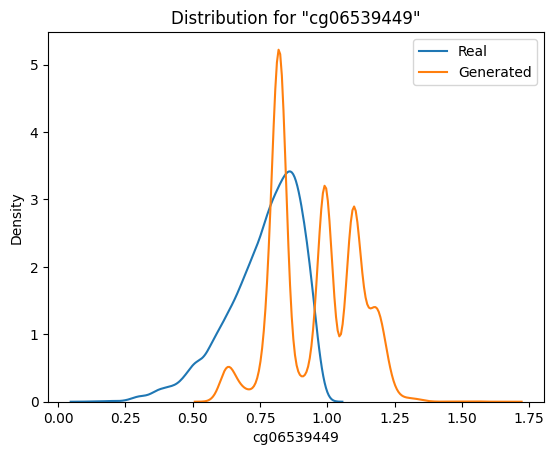

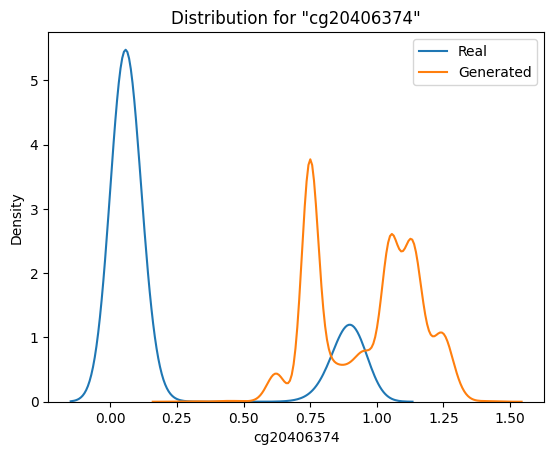

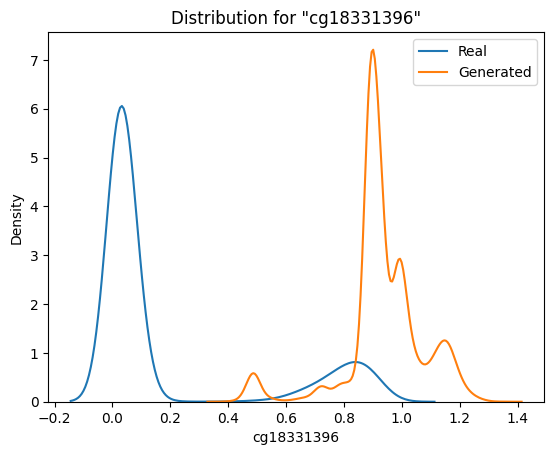

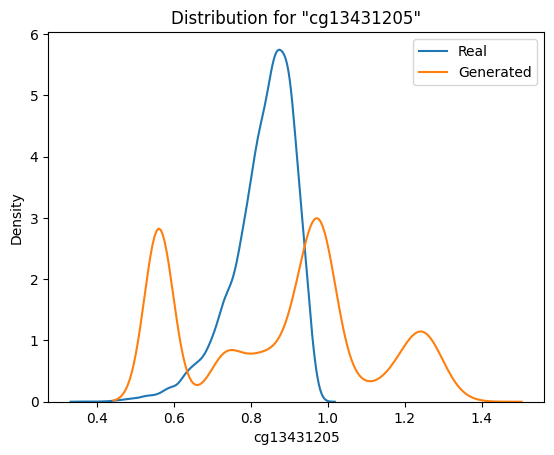

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import random

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)

# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"


# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Genera tus datos con el GAN (ejemplo)
# X_gan = generador(noise).data.cpu().numpy()  # Asume que tienes una función generador
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_modelB.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)
last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])

# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])


# Suponiendo que X_real y X_gan tienen las mismas columnas
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)

for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real')
    sns.kdeplot(X_gan[column_name], label='Generated')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.show()


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2370
           2       1.00      1.00      1.00       630

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



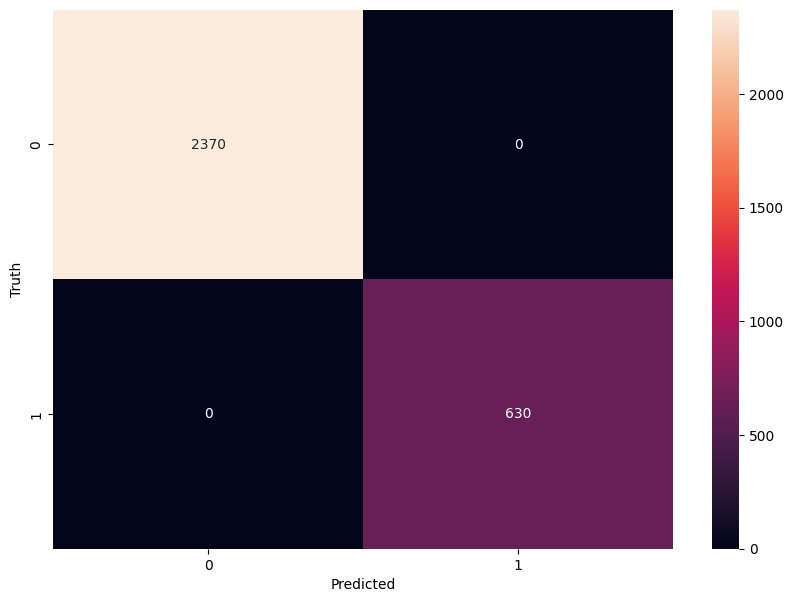

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = pd.concat([expr_data, meth_data], axis=1)
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


              precision    recall  f1-score   support

           1       1.00      1.00      1.00     23934
           2       1.00      1.00      1.00      6066

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



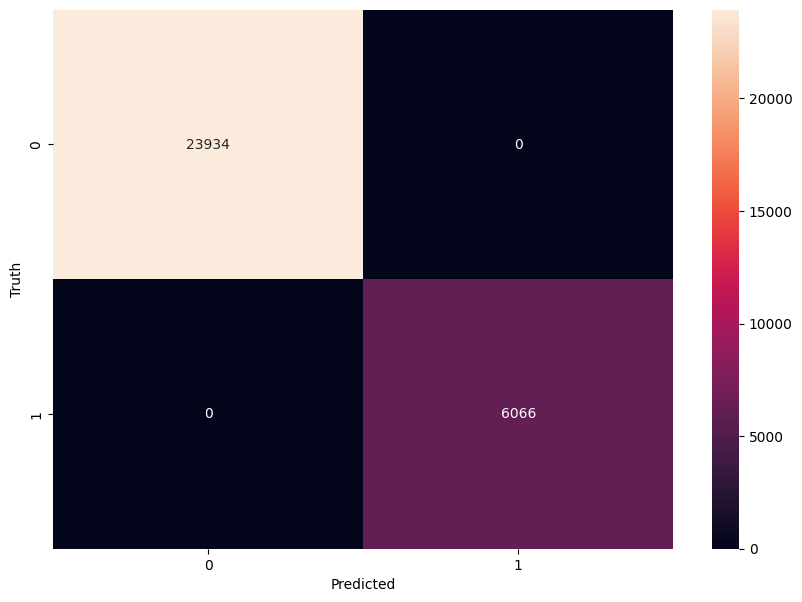

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprMID.csv')
meth_data = pd.read_csv('methylMID.csv')
assig_data = pd.read_csv('assignMID.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = meth_data
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
